In [1]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downnload and generate summary statistics of the observational data.

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("https://raw.githubusercontent.com/altdeep/causalML/master/datasets/sidequests_and_purchases_obs.csv")    #A
df.groupby(    #B
    ["Side-quest Engagement"]    #B
).agg(    #C
    ['count', 'mean', np.std]    #C
)


In-game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                482  111.609461  55.562334
low                                 518   73.096371  75.947688

Calculate significance.

In [3]:
summary = df.groupby(    #B
    ["Side-quest Engagement"]    #B
).agg(    #C
    ['count', 'mean', np.std]    #C
)
n1, n2 = summary['In-game Purchases']['count']    #D
m1, m2 = summary['In-game Purchases']['mean']    #E
s1, s2 =  summary['In-game Purchases']['std']    #F
pooled_std = (s1**2 / n1 + s2**2 / n2) **.5    #G
z_score = (m1 - m2) / pooled_std    #H
abs(z_score) > 2.    #I

True

Do the same for the experimental data.

In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv("https://raw.githubusercontent.com/altdeep/causalML/master/datasets/sidequests_and_purchases_exp.csv")    #A
summary = df.groupby(    #B
    ["Side-quest Engagement"]    #B
).agg(    #C
    ['count', 'mean', np.std]    #C
)
print(summary)
n1, n2 = summary['In-game Purchases']['count']    #D
m1, m2 = summary['In-game Purchases']['mean']    #E
s1, s2 =  summary['In-game Purchases']['std']    #F
pooled_std = (s1**2 / n1 + s2**2 / n2) **.5    #G
z_score = (m1 - m2) / pooled_std    #H
abs(z_score) > 2.    #I

                      In-game Purchases                      
                                  count       mean        std
Side-quest Engagement                                        
high                                500   92.99054  51.673631
low                                 500  131.38228  94.840705


True

```
#A Load the observational data from the database query into a pandas dataframe.
#B For each level of side-quest engagement ("low", "high")...
#C Calculate the sample count (number of players), the sample mean in-game purchase amount, and the standard deviation.
#D n1 and n2 are the number of players in each group (high vs low engagement).
#E m1 and m2 are the group sample means.
#F s1 and s2 are the group standard deviations.
#G Estimate the standard error of the difference in mean spend between the two groups by pooling (combining) the group standard deviations.
#H Convert to a z-score, a statistic that has a standard normal distribution (mean 0 and scale 1) under the (null) hypothesis that players spend on average the same way regardless of their level of engagement.
#I This tests if the z-score is more than 2 standard deviations from 0. It returns true.  There is only about a 2.3% chance having a z-score larger than 2 under the null hypothesis that engagement doesn't matter.  This indicates the difference is significant under a standard 5% significance threshold.
```

# Building a generative model for use in simulating the experiment with intervention.

Download full observational data with guild membership.  Calculate the marginal distribution of guild membership.

In [5]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/altdeep/causalML/master/datasets/sidequests_and_purchases_full_obs.csv")     #A

membership_counts = df['Guild Membership'].value_counts()    #B
dist_guild_membership = membership_counts / sum(membership_counts)    #B
print(dist_guild_membership)    #B

nonmember    0.515
member       0.485
Name: Guild Membership, dtype: float64


```
#A Load the data from the database query into a pandas dataframe.
#B Calculate the proportions of members vs. nonmembers 
```

For guild members and nonmembers respectively, calculate the probability distribution of side-quest engagement.


In [6]:
member_subset = df[df['Guild Membership'] == 'member']    #A
member_engagement_counts = member_subset['Side-quest Engagement'].value_counts()    #A
dist_engagement_member = member_engagement_counts / sum(member_engagement_counts)    #A
print(dist_engagement_member)    #A

nonmember_subset = df[df['Guild Membership'] == 'nonmember']    #B
nonmember_engagement_counts = nonmember_subset['Side-quest Engagement'].value_counts()    #B
dist_engagement_nonmember = nonmember_engagement_counts / sum(nonmember_engagement_counts)    #B
print(dist_engagement_nonmember)    #B

high    0.797938
low     0.202062
Name: Side-quest Engagement, dtype: float64
low     0.815534
high    0.184466
Name: Side-quest Engagement, dtype: float64


```
#A Calculate the probability distribution of side-quest engagement level ("high" vs "low") given that a player is a member of a guild.
#B Calculate the probability distribution of side-quest engagement level ("high" vs "low") given that a player is not a member of a guild.
```

For each combination of guild membership and side-quest engagement, calculate the mean and standard deviation of in-game purchases

In [7]:
purchase_dist_nonmember_low_engagement = df[    #A
    (df['Guild Membership'] == 'nonmember') &    #A
    (df['Side-quest Engagement'] == 'low')    #A
].agg(['mean', np.std])     #A
print(round(purchase_dist_nonmember_low_engagement, 2))    #A

purchase_dist_nonmember_high_engagement = df[    #B
    (df['Guild Membership'] == 'nonmember') &    #B
    (df['Side-quest Engagement'] == 'high')    #B
].agg(['mean', np.std])    #B
print(round(purchase_dist_nonmember_high_engagement, 2))    #B

purchase_dist_member_low_engagement = df[    #C
    (df['Guild Membership'] == 'member') &    #C
    (df['Side-quest Engagement'] == 'low')    #C
].agg(['mean', np.std])     #C
print(round(purchase_dist_member_low_engagement, 2))    #C

purchase_dist_member_high_engagement = df[    #D
    (df['Guild Membership'] == 'member') &    #D
    (df['Side-quest Engagement'] == 'high')    #D
].agg(['mean', np.std])     #D
print(round(purchase_dist_member_high_engagement, 2))    #D

      In-game Purchases
mean              37.95
std               23.80
      In-game Purchases
mean              54.92
std                4.92
      In-game Purchases
mean             223.71
std                5.30
      In-game Purchases
mean             125.53
std               53.44


```
#A Estimate the sample mean and standard deviation of in-game purchases for non-guild-members with low side-quest engagement.
#B Estimate the sample mean and standard deviation of in-game purchases for non-guild-members with high side-quest engagement.
#C Estimate the sample mean and standard deviation of in-game purchases for guild-members with low side-quest engagement.
#D Estimate the sample mean and standard deviation of in-game purchases for guild-members with high side-quest engagement.
```

Specify a generative model on the causal DAG.  Use the statistics calculated above as maximum likelihood estimates of model parameters.

In [8]:
import pyro
from torch import tensor
from pyro.distributions import Bernoulli, HalfNormal, Normal

def model():
    p_member = tensor(0.5)    #A
    is_guild_member = pyro.sample(    #A
        "Guild Membership",    #A
        Bernoulli(p_member)    #A
    )    #A
    p_engaged = (tensor(0.8)*is_guild_member +    #B
                 tensor(.2)*(1-is_guild_member))    #B
    is_highly_engaged = pyro.sample(    #B
        "Side-quest Engagement",    #B
        Bernoulli(p_engaged)    #B
    )    #B
    μ = (    #C
             37.95 * (1-is_guild_member) * (1 - is_highly_engaged) +    #C
             54.92 * (1-is_guild_member) * (is_highly_engaged) +    #C
            223.71 * (is_guild_member)   * (1 - is_highly_engaged) +    #C  
            125.50 * (is_guild_member)   * (is_highly_engaged)    #C
    )    #C
    σ = (    #D
             23.80 * (1-is_guild_member) * (1 - is_highly_engaged) +    #D
              4.92 * (1-is_guild_member) * (is_highly_engaged) +    #D
              5.30 * (is_guild_member)   * (1 - is_highly_engaged) +    #D
             53.49 * (is_guild_member)   * (is_highly_engaged)    #D
    )    #D
    if(is_guild_member == tensor(0.) and is_highly_engaged == tensor(0.)):   #E
        in_game_purchases = pyro.sample(    #E
            "In-game Purchases",    #E
            HalfNormal(μ, σ)    #E
        )    #E
    else:    #E
        in_game_purchases = pyro.sample("In-game Purchases", Normal(μ, σ))   #E

    guild_membership = "member" if is_guild_member else "nonmember"    #F
    engagement = "high" if is_highly_engaged else "low"    #F
    in_game_purchases = float(in_game_purchases)    #F

    return guild_membership, engagement, in_game_purchases

````
#A Probability of being a guild member vs a non-member is .5.  Using this probability, we generate a guild membership value from a Bernoulli distribution, where a value 1.0 indicates a member, and a value of 0.0 indicates a non-member.
#B We similarly generate a value for side-quest engagement form a Bernoulli distribution.  A value of 1.0 indicates high engagement and a value of 0.0 indicates low engagement. Side-quest engagement depends on guild membership. So we use the 1.0/0.0 value of is_guild_member to select between a .2 probability of being highly engaged in side-quests for guild members, and .8 probability of being highly engaged in side-quests for nonmembers. The math that uses 1.0/0.0 value of is_guild_member to select the value assigned to p_engaged is called an "indicator function." It is less Pythonic than using if-then statements, but it will allow pyro.render_model to derive the causal DAG.
#C Here we specify the mean parameter of a canonical distribution on in-game purchases using the sample means we found in the observational data.  Again, we use an indicator function approach to select the right value of the mean given guild membership and level of side-quest engagement.
#D As with the mean parameters, we specify the scale parameters for a canonical distribution on in-game purchases using the standard deviations we found in the data.
#E In every case except for non-guild-members with low side-quest engagement, we use as our canonical distribution for in-game purchases a normal distribution with mean and scale .  For non-guild-members, I don't feel comfortable using a normal distribution.  Generation from a normal distribution with a mean of 37.95 and scale parameter of 23.80 would have about a .055 probability of generating a negative value.  In-game purchases of course cannot be negative. This is not a big deal, but unlike pgmpy, pyro gives us tremendous parameteric flexibility. So for unengaged non-guild-members I use a half-normal distribution.  Generating from the half-normal distribution is the same as generating from the normal, except any negative values will have their sign changed to positive.  Since this will happen only about 5.5% of the time with negative values close to zero, it adds minimal bias to the mean for this group. 
#F Finally, we convert the variable values from tensors to the character strings and floats we see in the original data.
````

Confirm that the generative model adheres to the causal DAG structure using pyro.render.

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


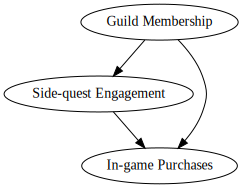

In [9]:
pyro.render_model(model)

Show that this model encodes both the observational and interventional distribution.

Observational:

In [10]:
pyro.util.set_rng_seed(123)
simulated_observational_data = [model() for _ in range(1000)]    
sim_full_obs_df = pd.DataFrame(
    simulated_observational_data,
    columns=["Guild Membership", "Side-quest Engagement", "In-Game Purchases"]
)
sim_obs_df = sim_full_obs_df.drop("Guild Membership", axis=1)
sim_obs_df.groupby(["Side-quest Engagement"]).agg(['count', 'mean', np.std])

In-Game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                500  108.961974  56.128941
low                                 500   65.915060  78.108363

Compare this to the observational distribution in the actual data.

In [11]:
df.drop("Guild Membership", axis=1).groupby(["Side-quest Engagement"]).agg(['count', 'mean', np.std])


In-game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                482  111.609461  55.562334
low                                 518   73.096371  75.947688

Next, simulate the experiment using the do operator.  Create two models, one that sets engagement to high, the other to low.

In [12]:
int_engaged_model = pyro.do(    #A
    model,    #A
    {"Side-quest Engagement": tensor(1.)}    #A
)    #A
int_unengaged_model = pyro.do(    #B
    model,    #B
    {"Side-quest Engagement": tensor(0.)}    #B
)    #B



```
#A An intervention that sets Side-quest Engagement to 1.0 (i.e "high").  This returns a new model.
#B An intervention that sets Side-quest Engagement to 0.0 (i.e. "low").  This returns a new model.
```

Simulate from both models and combine the results to get experimental data.

In [13]:
pyro.util.set_rng_seed(123)    #A
simulated_experimental_data = [    #B
    int_engaged_model() for _ in range(500)    #B
] + [    #B
    int_unengaged_model() for _ in range(500)    #B
]    #B
simulated_experimental_data = pd.DataFrame(    #B
    simulated_experimental_data,    #B
    columns=[    #B
        "Guild Membership", "Side-quest Engagement", "In-Game Purchases"    #B
    ]    #B
)    #B
sim_exp_df = simulated_experimental_data.drop("Guild Membership", axis=1)    #C
summary = sim_exp_df.groupby(    #D
        ["Side-quest Engagement"]    #D
    ).agg(    #D
        ['count', 'mean', np.std]    #D
    )    #D
print(summary)    #D

                      In-Game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                500   89.897309  52.696709
low                                 500  126.222026  98.179060


```
#A Setting a random seed for reproducibility. 
#B Simulate 500 rows from each intervention model and combined them to create simulated experimental data.
#C The simulated data will include a Guild Membership column.  We can drop it to get simulated data that looks like the original experiment.
#D Recreate the statistical summaries of in-game purchase for each level of engagement.
```

Compare the results to the actual experimental data.

In [14]:
exp_df = pd.read_csv("https://raw.githubusercontent.com/altdeep/causalML/master/datasets/sidequests_and_purchases_exp.csv")

summary = exp_df.groupby(
        ["Side-quest Engagement"]
    ).agg(
        ['count', 'mean', np.std]
    )
print(summary)

                      In-game Purchases                      
                                  count       mean        std
Side-quest Engagement                                        
high                                500   92.99054  51.673631
low                                 500  131.38228  94.840705
